In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('lenta_40k.csv')

In [4]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [8]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [9]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [32]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [33]:
MAX_LEN = max(len(x) for x in X)

MEAN_LEN = np.median([len(x) for x in X])

MAX_LEN = int(MEAN_LEN + 10)

In [34]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [35]:
X.shape

(44356, 180)

In [36]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [37]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

### GRU

In [18]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [20]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 [==============================] - 205s 5s/step - loss: 0.8409 - f1: 0.6947 - rec@prec: 0.6391 - val_loss: 1.4981 - val_f1: 0.5522 - val_rec@prec: 0.2962
Epoch 2/10
43/43 [==============================] - 206s 5s/step - loss: 0.7346 - f1: 0.7497 - rec@prec: 0.7357 - val_loss: 1.5150 - val_f1: 0.5887 - val_rec@prec: 0.3273
Epoch 3/10
43/43 [==============================] - 206s 5s/step - loss: 0.6475 - f1: 0.7863 - rec@prec: 0.7996 - val_loss: 1.5169 - val_f1: 0.6084 - val_rec@prec: 0.3841
Epoch 4/10
43/43 [==============================] - 205s 5s/step - loss: 0.5572 - f1: 0.8253 - rec@prec: 0.8555 - val_loss: 1.5515 - val_f1: 0.6132 - val_rec@prec: 0.4175
Epoch 5/10
43/43 [==============================] - 203s 5s/step - loss: 0.4963 - f1: 0.8467 - rec@prec: 0.8838 - val_loss: 1.7822 - val_f1: 0.6017 - val_rec@prec: 0.3305
Epoch 6/10
43/43 [==============================] - 203s 5s/step - loss: 0.4630 - f1: 0.8604 - rec@prec: 0.9037 - val_loss: 1.5859 - val_f1: 0.62

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


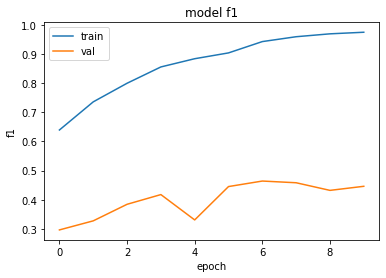

In [21]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### LSTM 

Epoch 1/10
22/22 [==============================] - 236s 10s/step - loss: 2.6321 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3631 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
22/22 [==============================] - 314s 14s/step - loss: 2.3312 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3219 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
22/22 [==============================] - 298s 14s/step - loss: 2.3139 - f1: 0.0000e+00 - rec@prec: 2.3732e-05 - val_loss: 2.3062 - val_f1: 0.0000e+00 - val_rec@prec: 0.0027
Epoch 4/10
22/22 [==============================] - 287s 13s/step - loss: 2.2893 - f1: 0.0000e+00 - rec@prec: 4.7463e-05 - val_loss: 2.2798 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 5/10
22/22 [==============================] - 190s 9s/step - loss: 2.2395 - f1: 0.0000e+00 - rec@prec: 2.8478e-04 - val_loss: 2.1524 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 6/10
22/22 [==============================] - 163s 7s/step - loss: 

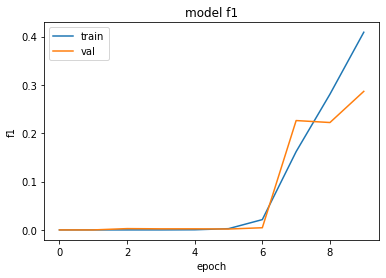

In [24]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

lstm = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

lstm.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

print(lstm.history.history.keys())
# summarize history for accuracy
plt.plot(lstm.history.history['rec@prec'])
plt.plot(lstm.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### GRU и LSTM 

Epoch 1/10
22/22 [==============================] - 377s 17s/step - loss: 2.5559 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3316 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
22/22 [==============================] - 362s 16s/step - loss: 2.3246 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3170 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
22/22 [==============================] - 373s 17s/step - loss: 2.3083 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2556 - val_f1: 0.0000e+00 - val_rec@prec: 4.5086e-04
Epoch 4/10
22/22 [==============================] - 350s 16s/step - loss: 2.0985 - f1: 0.0246 - rec@prec: 0.0235 - val_loss: 1.9662 - val_f1: 0.0540 - val_rec@prec: 0.0415
Epoch 5/10
22/22 [==============================] - 348s 16s/step - loss: 1.8263 - f1: 0.1091 - rec@prec: 0.0637 - val_loss: 1.7634 - val_f1: 0.1208 - val_rec@prec: 0.0708
Epoch 6/10
22/22 [==============================] - 347s 16s/step - loss: 1.6655 - f1: 0.135

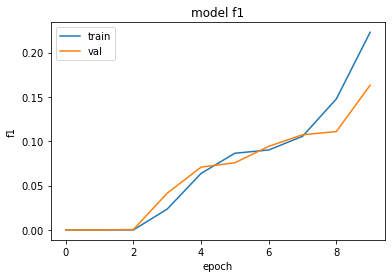

In [26]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm = tf.keras.layers.LSTM(128, return_sequences=False)(gru)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### BIGRU и 2 LSTM

Epoch 1/10
22/22 [==============================] - 1718s 78s/step - loss: 2.5643 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3461 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
22/22 [==============================] - 1872s 85s/step - loss: 2.3337 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3239 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
22/22 [==============================] - 2654s 122s/step - loss: 2.3220 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3145 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/10
22/22 [==============================] - 3050s 138s/step - loss: 2.2104 - f1: 0.0000e+00 - rec@prec: 0.0029 - val_loss: 1.9774 - val_f1: 0.0000e+00 - val_rec@prec: 0.0158
Epoch 5/10
22/22 [==============================] - 2249s 101s/step - loss: 1.8377 - f1: 0.0868 - rec@prec: 0.0514 - val_loss: 1.7404 - val_f1: 0.1222 - val_rec@prec: 0.0676
Epoch 6/10
22/22 [==============================] - 1996s 91s/step - loss: 1

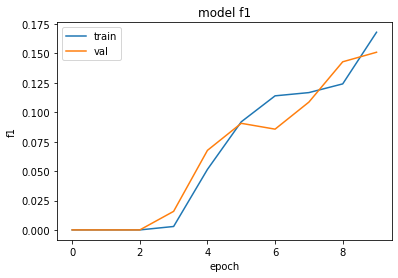

In [27]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 5 GRU и 3 LSTM

In [40]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/10


KeyboardInterrupt: 

### 1 BIGRU и 1 BILSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs, )

bigru_forward = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True),
    backward_layer=tf.keras.layers.GRU(32, return_sequences=True, go_backwards=True)
    )(embeddings)

bilstm_backward = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, return_sequences=False),
    backward_layer=tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True)
    )(bigru_fw)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bilstm_bw)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

### LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru = tf.keras.layers.GRU(128, return_sequences=True)(lstm)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bilstm)
gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_1)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**модели обучаются невыносимо долго и почти полностью сжирают компьютер (чем больше слоёв, тем хуже), поэтому последние три я решила не обучать. к тому же качество с каждым новым слоем падает. из обученных моделей лучше всего себя показала модель с одним слоем gru**

# Задание 2

In [2]:
!pip install datasets

  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0


In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to C:\Users\howto\.cache\huggingface\datasets\wikiann\ru\1.1.0\4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)
    
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)
    
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

#### BILSTM

In [8]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

bilstm_model = tf.keras.Model(inputs=inputs, outputs=outputs)
bilstm_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

bilstm_model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5)

Epoch 1/5
157/157 [==============================] - 258s 2s/step - loss: 0.2547 - accuracy: 0.9307 - val_loss: 0.1473 - val_accuracy: 0.9539
Epoch 2/5
157/157 [==============================] - 233s 1s/step - loss: 0.1230 - accuracy: 0.9605 - val_loss: 0.1003 - val_accuracy: 0.9687
Epoch 3/5
157/157 [==============================] - 233s 1s/step - loss: 0.0571 - accuracy: 0.9823 - val_loss: 0.0544 - val_accuracy: 0.9831
Epoch 4/5
157/157 [==============================] - 233s 1s/step - loss: 0.0205 - accuracy: 0.9942 - val_loss: 0.0535 - val_accuracy: 0.9836
Epoch 5/5
157/157 [==============================] - 230s 1s/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.0571 - val_accuracy: 0.9836


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


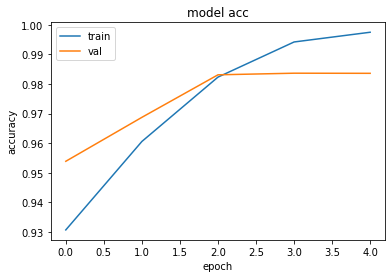

In [9]:
print(bilstm_model.history.history.keys())
plt.plot(bilstm_model.history.history['accuracy'])
plt.plot(bilstm_model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### BIGRU

Epoch 1/5
157/157 [==============================] - 213s 1s/step - loss: 0.2454 - accuracy: 0.9328 - val_loss: 0.1101 - val_accuracy: 0.9640
Epoch 2/5
157/157 [==============================] - 194s 1s/step - loss: 0.0617 - accuracy: 0.9809 - val_loss: 0.0509 - val_accuracy: 0.9845
Epoch 3/5
157/157 [==============================] - 201s 1s/step - loss: 0.0191 - accuracy: 0.9945 - val_loss: 0.0597 - val_accuracy: 0.9824
Epoch 4/5
157/157 [==============================] - 202s 1s/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.0553 - val_accuracy: 0.9844
Epoch 5/5
157/157 [==============================] - 201s 1s/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0617 - val_accuracy: 0.9838
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


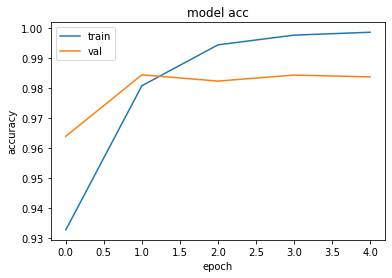

In [11]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru_2)

bigru_model = tf.keras.Model(inputs=inputs, outputs=outputs)
bigru_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

bigru_model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5)

print(bigru_model.history.history.keys())
plt.plot(bigru_model.history.history['accuracy'])
plt.plot(bigru_model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [15]:
label_seq('Олеся купила новые часы в Киеве, которые подарит Евгении', word2id, id2labels, MAX_LEN, bilstm_model)

1/1 [==============================] - 5s 5s/step


[('Олеся', 'B-LOC'),
 ('купила', 'I-LOC'),
 ('новые', 'O'),
 ('часы', 'O'),
 ('в', 'O'),
 ('Киеве', 'B-LOC'),
 (',', 'O'),
 ('которые', 'O'),
 ('подарит', 'B-LOC'),
 ('Евгении', 'O')]

In [16]:
label_seq('Олеся купила новые часы в Киеве, которые подарит Евгении', word2id, id2labels, MAX_LEN, bigru_model)

1/1 [==============================] - 4s 4s/step


[('Олеся', 'B-PER'),
 ('купила', 'O'),
 ('новые', 'O'),
 ('часы', 'O'),
 ('в', 'O'),
 ('Киеве', 'B-LOC'),
 (',', 'O'),
 ('которые', 'O'),
 ('подарит', 'O'),
 ('Евгении', 'O')]

In [17]:
label_seq('Кандид снова попытался его обойти и снова каким-то образом оказался с ним носом к носу', word2id, id2labels, MAX_LEN, bilstm_model)

1/1 [==============================] - 0s 72ms/step


[('Кандид', 'B-LOC'),
 ('снова', 'O'),
 ('попытался', 'O'),
 ('его', 'O'),
 ('обойти', 'O'),
 ('и', 'O'),
 ('снова', 'O'),
 ('каким', 'O'),
 ('-', 'O'),
 ('то', 'O'),
 ('образом', 'O'),
 ('оказался', 'O'),
 ('с', 'O'),
 ('ним', 'O'),
 ('носом', 'B-LOC'),
 ('к', 'O'),
 ('носу', 'B-LOC')]

In [18]:
label_seq('Кандид снова попытался его обойти и снова каким-то образом оказался с ним носом к носу', word2id, id2labels, MAX_LEN, bigru_model)

1/1 [==============================] - 0s 57ms/step


[('Кандид', 'O'),
 ('снова', 'O'),
 ('попытался', 'O'),
 ('его', 'O'),
 ('обойти', 'O'),
 ('и', 'O'),
 ('снова', 'O'),
 ('каким', 'O'),
 ('-', 'O'),
 ('то', 'O'),
 ('образом', 'O'),
 ('оказался', 'O'),
 ('с', 'O'),
 ('ним', 'O'),
 ('носом', 'O'),
 ('к', 'O'),
 ('носу', 'O')]

**В целом, обе модели работают похоже; bigru определяет сущности совсем несного лучше (хотя с определением сложного имени лучше справилась модель bilstm (но и нос она тоже почему-то определила как сущность))**